# Creating a Choropleth Map of the World in Python using GeoPandas

There are different ways of creating choropleth maps in Python. In a [previous notebook](http://ramiro.org/notebook/basemap-choropleth/), I showed how you can use the Basemap library to accomplish this. More than 2 years have passed since publication and the available tools have evolved a lot. In this notebook I use the [GeoPandas library](http://geopandas.org/) to create a choropleth map. As you'll see the code is more concise and easier to follow along.

To allow for better comparison of the 2 approaches I'll again use a World Bank dataset, but to make it a bit more interesting the map will show the number of [Individuals using the Internet (% of population)](https://data.worldbank.org/indicator/IT.NET.USER.ZS) based on the International Telecommunication Union, World Telecommunication/ICT Development Report and database.

## Setup

Load the necessary modules and specify the files for input and output, set the number of colors to use, the size of the figure in inches (width, height) and meta information about what is displayed.

In [1]:
%load_ext signature
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from helpers import slug

datafile = os.path.expanduser('~/data/worldbank/API_IT.NET.USER.ZS_DS2_en_csv_v2.csv')
shapefile = os.path.expanduser('~/data/geo/naturalearthdata.com/ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp')

colors = 9
cmap = 'Blues'
figsize = (16, 10)
year = '2016'
cols = ['Country Name', 'Country Code', year]
title = 'Individuals using the Internet (% of population) in {}'.format(year)
imgfile = 'img/{}.png'.format(slug(title))

descripton = '''
Individuals who have used the Internet from any location in the last 3 months via any device based on the International Telecommunication Union,
World Telecommunication/ICT Development Report and database. Data: World Bank - worldbank.org • Author: Ramiro Gómez - ramiro.org'''.strip()

Create a [GeoDataFrame](http://geopandas.org/data_structures.html#geodataframe) from the *Admin 0 - Countries* shapefile available from [Natural Earth Data](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/) and show a sample of 5 records. We only read the ``ADM0_A3`` and ``geometry`` columns, which contain the 3-letter country codes defined in [ISO 3166-1 alpha-3](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) and the country shapes as polygons respectively.

In [2]:
gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
gdf.sample(5)

,ADM0_A3,geometry
176,PCN,(POLYGON ((-11956315.49000262 -2681832.5050170...
254,ZWE,POLYGON ((2840486.942817139 -1672299.128655995...
53,CRI,(POLYGON ((-8215217.966553865 589948.691312572...
64,DNK,"(POLYGON ((888305.04768235 5833775.867939749, ..."
107,IRL,(POLYGON ((-796000.6321138854 5495858.23880455...


Next read the datafile downloaded from the [World Bank Open Data](https://data.worldbank.org/) site and create a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) that contains values for ``Country Code``,  ``Country Name`` and the percentages of Internet users in the year ``2016``.

In [3]:
df = pd.read_csv(datafile, skiprows=4, usecols=cols)
df.sample(5)

,Country Name,Country Code,2016
87,Greece,GRC,69.087915
203,Saudi Arabia,SAU,73.750904
42,"Congo, Rep.",COG,8.121949
73,Finland,FIN,87.703650
197,French Polynesia,PYF,68.440419


Next we [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) the data frames on the columns containing the 3-letter country codes and show  summary statistics as returned from the [describe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html) method.

In [4]:
merged = gdf.merge(df, left_on='ADM0_A3', right_on='Country Code')
merged.describe()

,2016
count,201.000000
mean,51.417892
std,28.569949
min,1.177119
25%,25.366301
50%,54.000000
75%,76.409085
max,98.240016


## Mapping the data

The merge operation above returned a GeoDataFrame. From this data structure it is very easy to create a choropleth map by invoking the ``plot`` method. We need to specify the ``column`` to plot and since we don't want a continuous color scale we set ``scheme`` to ``equal_interval`` and the number of classes ``k`` to ``9``. We also set the size of the figure and show a legend in the plot.

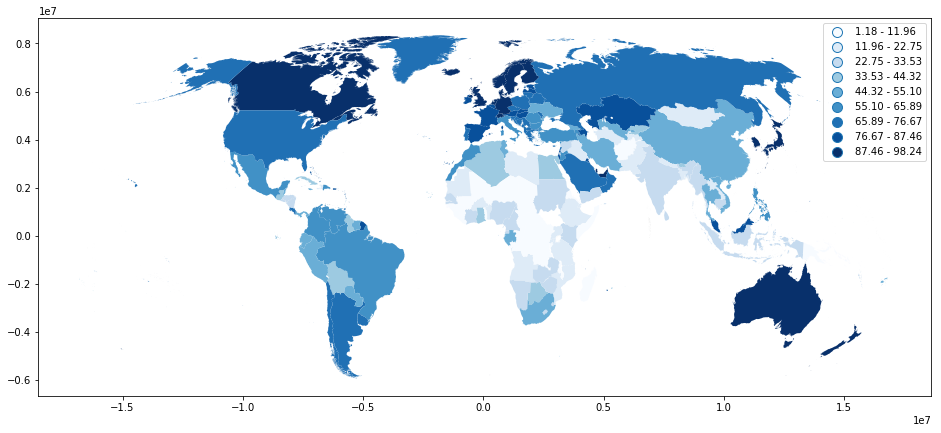

In [5]:
ax = merged.dropna().plot(column=year, cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)

This is pretty nice already, but before publishing this map, there remains some work to be done. As is often the case, some data is missing. You may or may not have noticed it, but the corresponding countries are not shown at all, look for North Korea. The call to ``dropna()`` right before the ``plot()`` call removed these records from the plotted GeoDataFrame.

We could just leave it like that, because we simply don't know the values, but I'm sure that would put off some people. So let's draw these countries using a light gray as done in the [Basemap example](http://ramiro.org/notebook/basemap-choropleth/).

Moreover, the image taken by itself provides no clue about what is shown, so we'll add a title and an annotation. Also we to turn off the axes, cut off some space in the far west and east, and move the legend to the lower left of the figure, because there is more empty space.

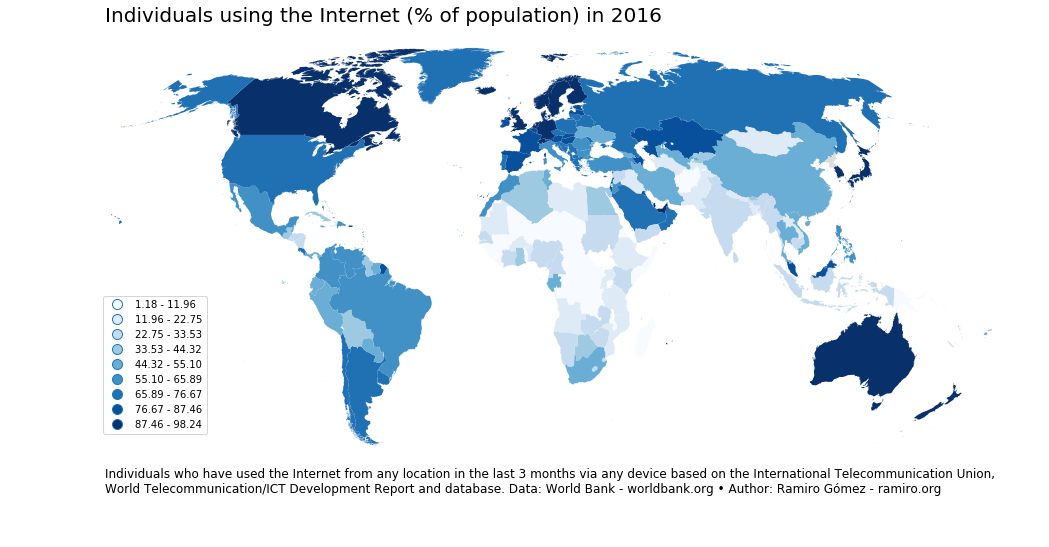

<Figure size 432x288 with 0 Axes>

In [6]:
merged[merged.isna().any(axis=1)].plot(ax=ax, color='#dddddd')

ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
ax.annotate(descripton, xy=(0.1, 0.1), size=12, xycoords='figure fraction')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.get_figure()

I think this map is fine for publication and the code is pretty easy to follow, but there is some room for improvement as far as I'm concerned. For example reducing the left and right margins, turning off axis display and specifying a color, or even a background pattern as done [in this map](http://ramiro.org/map/world/rplace-country-color-propensity/), for missing data via parameters to the ``plot`` method would be nice to have. In any case, I think the GeoPandas project is headed in a good direction and hope it will continue to evolve as a library for analyzing and mapping geographic data in Python.

In [7]:
%signature